In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
from torch.optim.lr_scheduler import StepLR

In [ ]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
path = '/content/drive/MyDrive/Dataset/KaggleV2-May-2016.csv'
df = pd.read_csv(path)
df = df.copy()

In [ ]:
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

In [ ]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['WaitingTime'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

df = df[df['WaitingTime'] >= 0].copy()
df.loc[:, 'AppointmentWeekday'] = df['AppointmentDay'].dt.dayofweek
# df.loc[:, 'Neighbourhood'] = pd.factorize(df['Neighbourhood'])[0]

# df['Neighbourhood'] = pd.factorize(df['Neighbourhood'])[0]
# print(df['Neighbourhood'].dtype)



features = [
    'Gender', 'Age',  'Scholarship',
    'Hipertension', 'Diabetes' , 'Handcap',
    'SMS_received', 'WaitingTime', 'AppointmentWeekday'
]
# print(df[features].isnull().sum())
# print(np.isinf(df[features]).sum())
# print(df[features].dtypes)


In [ ]:
X = df[features].to_numpy()
y = df['No-show'].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1

X_scaled = (X - X_mean) / X_std

# --------------------  Shuffle and Split --------------------
np.random.seed(42)
indices = np.arange(X_scaled.shape[0])
np.random.shuffle(indices)

# 80-20 split
split_idx = int(0.8 * len(indices))
train_idx, val_idx = indices[:split_idx], indices[split_idx:]

X_train, y_train = X_scaled[train_idx], y[train_idx]
X_val, y_val = X_scaled[val_idx], y[val_idx]

In [ ]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)

train_ds = TensorDataset(X_train, y_train.float())
val_ds = TensorDataset(X_val, y_val.float())

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1024)


In [ ]:
input_size = X_train.shape[1]
l1  = 64
l2 = 32
l3 = 1
initial_lr = 0.1
decay_rate = 0.01
num_epochs = 2000

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size,l1, l2, l3):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, l3)
    def forward(self, x):
        out = F.relu(self.l1(x))
        out = F.relu(self.l2(out))
        out = (self.l3(out))
        return out


In [ ]:
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()], dtype=torch.float32)
pos_weight = pos_weight.to(device)

print(pos_weight)

tensor([2.5222], device='cuda:0')


In [ ]:
model = NeuralNet(input_size, l1, l2, l3).to(device)

In [ ]:
loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

In [ ]:
from tqdm import trange,tqdm

In [ ]:
loss_history = []

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 / (1 + decay_rate * epoch))

In [ ]:
loss_history = []
lr_history = []

start_time = time.time()

for epoch in trange(num_epochs, desc="Training Epochs"):
    epoch_loss = 0

    num_batches = 0

    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb).squeeze()
        loss_value = loss(logits, yb)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        epoch_loss += loss_value.item()
        num_batches += 1

    # Call scheduler once per epoch
    scheduler.step()

    epoch_loss /= num_batches
    loss_history.append(epoch_loss)

    #  current LR from optimizer
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)

    if epoch % 100 == 0:
        tqdm.write(f"Epoch {epoch}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}")

end_time = time.time()
Convergence_time = end_time - start_time



Training Epochs:   0%|          | 1/2000 [00:01<37:35,  1.13s/it]

Epoch 0, Loss: 0.9916, LR: 0.099010


Training Epochs:   5%|▌         | 101/2000 [01:33<30:14,  1.05it/s]

Epoch 100, Loss: 0.9675, LR: 0.049751


Training Epochs:  10%|█         | 201/2000 [03:07<32:13,  1.07s/it]

Epoch 200, Loss: 0.9663, LR: 0.033223


Training Epochs:  15%|█▌        | 301/2000 [04:40<31:16,  1.10s/it]

Epoch 300, Loss: 0.9641, LR: 0.024938


Training Epochs:  20%|██        | 401/2000 [06:16<29:53,  1.12s/it]

Epoch 400, Loss: 0.9641, LR: 0.019960


Training Epochs:  25%|██▌       | 501/2000 [07:51<25:36,  1.02s/it]

Epoch 500, Loss: 0.9630, LR: 0.016639


Training Epochs:  30%|███       | 601/2000 [09:17<11:39,  2.00it/s]

Epoch 600, Loss: 0.9630, LR: 0.014265


Training Epochs:  35%|███▌      | 701/2000 [10:13<10:43,  2.02it/s]

Epoch 700, Loss: 0.9619, LR: 0.012484


Training Epochs:  40%|████      | 801/2000 [11:08<10:31,  1.90it/s]

Epoch 800, Loss: 0.9621, LR: 0.011099


Training Epochs:  45%|████▌     | 901/2000 [12:04<10:21,  1.77it/s]

Epoch 900, Loss: 0.9607, LR: 0.009990


Training Epochs:  50%|█████     | 1001/2000 [13:01<12:03,  1.38it/s]

Epoch 1000, Loss: 0.9612, LR: 0.009083


Training Epochs:  55%|█████▌    | 1101/2000 [13:58<08:17,  1.81it/s]

Epoch 1100, Loss: 0.9609, LR: 0.008326


Training Epochs:  60%|██████    | 1201/2000 [14:54<06:53,  1.93it/s]

Epoch 1200, Loss: 0.9608, LR: 0.007686


Training Epochs:  65%|██████▌   | 1301/2000 [15:50<05:55,  1.97it/s]

Epoch 1300, Loss: 0.9601, LR: 0.007138


Training Epochs:  70%|███████   | 1401/2000 [16:47<05:08,  1.94it/s]

Epoch 1400, Loss: 0.9605, LR: 0.006662


Training Epochs:  75%|███████▌  | 1501/2000 [17:48<05:13,  1.59it/s]

Epoch 1500, Loss: 0.9612, LR: 0.006246


Training Epochs:  80%|████████  | 1601/2000 [18:49<03:38,  1.82it/s]

Epoch 1600, Loss: 0.9608, LR: 0.005879


Training Epochs:  85%|████████▌ | 1701/2000 [19:56<03:06,  1.60it/s]

Epoch 1700, Loss: 0.9594, LR: 0.005552


Training Epochs:  90%|█████████ | 1801/2000 [21:03<01:59,  1.66it/s]

Epoch 1800, Loss: 0.9600, LR: 0.005260


Training Epochs:  95%|█████████▌| 1901/2000 [22:06<01:21,  1.22it/s]

Epoch 1900, Loss: 0.9603, LR: 0.004998


Training Epochs: 100%|██████████| 2000/2000 [23:10<00:00,  1.44it/s]


In [ ]:
print(f"Training time: {Convergence_time:.2f} seconds")

Training time: 1390.46 seconds


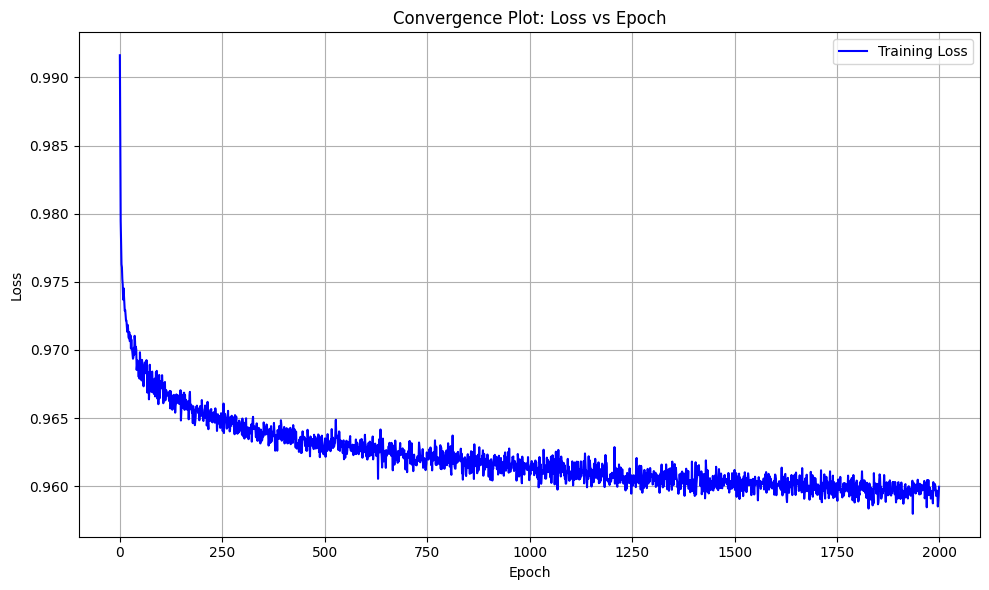

In [ ]:
epochs = range(len(loss_history))
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_history, label='Training Loss', color='blue')
plt.title('Convergence Plot: Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

np.savez('run2_metrics.npz', loss_history=loss_history, time_steps=np.linspace(0, Convergence_time, len(loss_history)))


In [ ]:
all_preds = []
all_probs = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits = model(xb).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        all_preds.append(preds)
        all_probs.append(probs)

preds = torch.cat(all_preds).cpu().numpy()
pred_probs = torch.cat(all_probs).cpu().numpy()


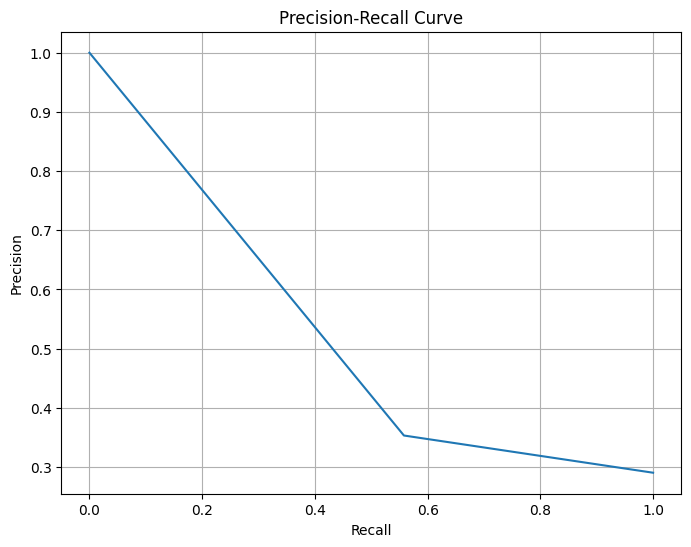

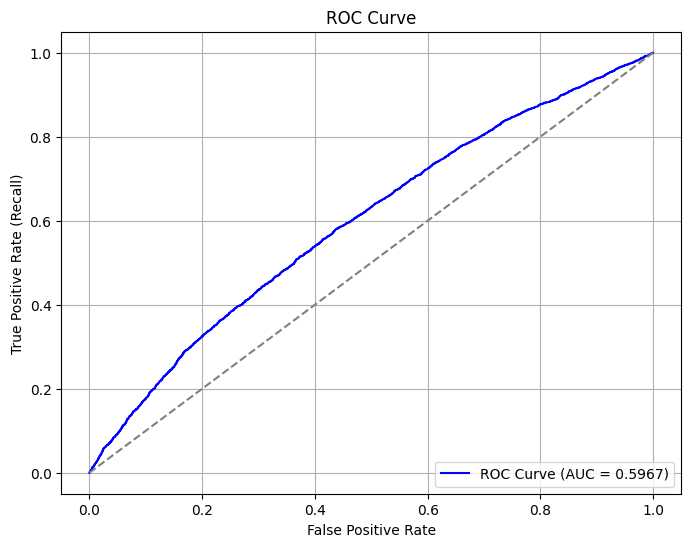

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, confusion_matrix, precision_recall_curve,roc_curve, roc_auc_score, recall_score, precision_score

prec, rec, thresholds = precision_recall_curve(y_val, preds)
plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, pred_probs)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_val, pred_probs)

# Plotting the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Accuracy
acc = accuracy_score(y_val, preds)

# F1-score
f1 = f1_score(y_val, preds)

# Precision-Recall AUC
pr_auc = average_precision_score(y_val, pred_probs)

# Recall
recall = recall_score(y_val, preds)
precision = precision_score(y_val,preds)

# Confusion Matrix
cm = confusion_matrix(y_val, preds)

# Results
print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("Confusion Matrix:")
print(cm)


Accuracy: 0.5750
F1-score: 0.4325
Recall: 0.5579
Precision: 0.3532
PR-AUC: 0.3691
Confusion Matrix:
[[5945 4269]
 [1847 2331]]


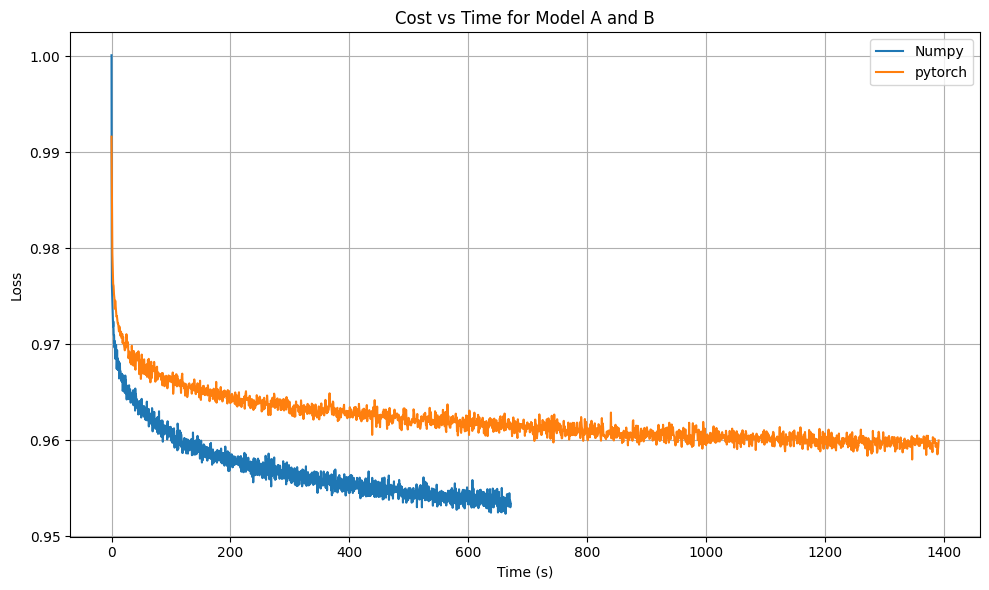

In [ ]:

run1 = np.load('run1_metrics.npz')
run2 = np.load('run2_metrics.npz')


plt.figure(figsize=(10,6))
plt.plot(run1['time_steps'], run1['loss_history'], label='Numpy')
plt.plot(run2['time_steps'], run2['loss_history'], label='pytorch')
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("Cost vs Time for Model A and B")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

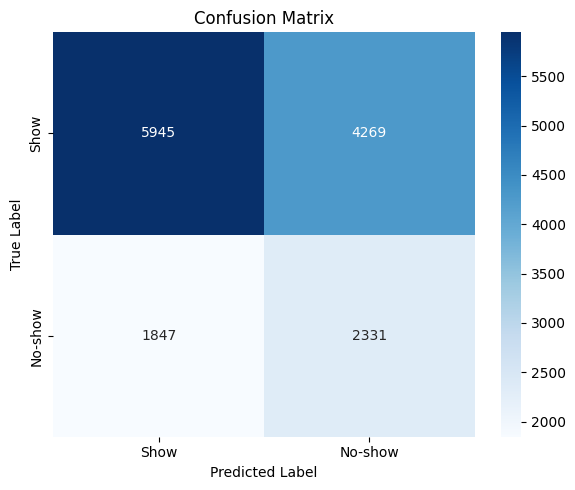

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_val, preds)

#  class labels
labels = ['Show', 'No-show']  # 0 = Show, 1 = No-show

#  confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
